Notes:
 * revised and tuned configuration, updated views
 * training on full dataset (iuncluding Y3, with caveats)

In [1]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/revised_tuned_31_run_1'
data_files = '/mnt/tess/astronet/tfrecords-31-val/*'
tces_file = '/mnt/tess/astronet/tces-v9-val.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/revised_tuned_31_run_1/1/AstroCNNModel_revised_tuned_20211204_211758',
 '/mnt/tess/astronet/checkpoints/revised_tuned_31_run_1/2/AstroCNNModel_revised_tuned_20211204_212214',
 '/mnt/tess/astronet/checkpoints/revised_tuned_31_run_1/3/AstroCNNModel_revised_tuned_20211204_212620',
 '/mnt/tess/astronet/checkpoints/revised_tuned_31_run_1/4/AstroCNNModel_revised_tuned_20211204_213028',
 '/mnt/tess/astronet/checkpoints/revised_tuned_31_run_1/5/AstroCNNModel_revised_tuned_20211204_213434',
 '/mnt/tess/astronet/checkpoints/revised_tuned_31_run_1/6/AstroCNNModel_revised_tuned_20211204_213840',
 '/mnt/tess/astronet/checkpoints/revised_tuned_31_run_1/7/AstroCNNModel_revised_tuned_20211204_214242',
 '/mnt/tess/astronet/checkpoints/revised_tuned_31_run_1/8/AstroCNNModel_revised_tuned_20211204_214650',
 '/mnt/tess/astronet/checkpoints/revised_tuned_31_run_1/9/AstroCNNModel_revised_tuned_20211204_215058',
 '/mnt/tess/astronet/checkpoints/revised_tuned_31_run_1/10/Astro

In [2]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
2504 records
Running model 2
2504 records
Running model 3
2504 records
Running model 4
2504 records
Running model 5
2504 records
Running model 6
2504 records
Running model 7
2504 records
Running model 8
2504 records
Running model 9
2504 records
Running model 10
2504 records


In [3]:
labels = ['disp_e', 'disp_n', 'disp_j', 'disp_s', 'disp_b']

col_e = labels.index('disp_e')
thresh = 0.030499761581475493

In [4]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for tic_id in preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[tic_id].append('disp_e')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[tic_id].append(preds.columns[np.argmax(masked_v)])

In [5]:
final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [6]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
for l in labels:
    tce_table[l] = tce_table[l[:-1] + l[-1].upper()]
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [7]:
ppos = (pl['disp_e_p'] > 0)
pos = (pl['disp_e'] > 0)

pneg = (pl['disp_e_p'] == 0)
neg = (pl['disp_e'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.9961685823754789
Precision: 0.4173354735152488


In [8]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

158159741


In [9]:
for i in pl[neg & ppos][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

163367359
16740282
185607431
188258751
188655930
1954685032
1958987309
199376584
202685576
230523116
243596276
26538131
275658545
277854181
356776209
416282321
64418963
136651206
164266012
233839656
239639659
24860612
277848886
278555119
278910035
295206687
298972209
312821931
330131047
330470939
357302392
364968470
395986110
417208086
431416493
469465627
2041994942
252588526
409455240
431338538
60959009
115917234
117170301
192591652
196919670
240897594
240967708
250477646
279064110
309230360
312060273
320490507
332870317
347492958
364181005
381847922
445298766
470782551
622842565
77424138
94280922
127846210
21133246
251788762
261814771
269291226
316133741
368663613
391032362
408602527
408945155
428453920
428942240
445700898
470309381
648359612
82242456
138652182
139402175
142615793
142751024
147607082
147608359
149918668
154491644
158436739
159528102
237278147
259167514
262970987
270279719
27896467
289623768
356822358
359393651
359631482
377253895
394010139
39573593
405687343
47008580

In [10]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 404220255)

,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,
404220255,0.276000,0.093484,0.167312,0.000472,0.546849
404220255,0.148314,0.073819,0.156295,0.000962,0.716159
404220255,0.635315,0.067686,0.118752,0.001075,0.198928
404220255,0.230886,0.069548,0.125013,0.002074,0.632436
404220255,0.044347,0.128922,0.229654,0.000949,0.803343
404220255,0.257819,0.081626,0.113061,0.001822,0.665179
404220255,0.704294,0.077049,0.112604,0.002029,0.132321
404220255,0.118482,0.043071,0.120573,0.000213,0.800211
404220255,0.128351,0.072165,0.204071,0.000150,0.683822


In [11]:
pl[pl.index == 421845505]

,disp_e_p,disp_n_p,disp_j_p,disp_s_p,disp_b_p,maxcount,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,,,,,,,


### PR curve

In [12]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_e = row[0], row[1][col_e]
        pred_es[i][tic_index[tic]] = pred_e

lbl_es = np.zeros([len(tic_index)], dtype=np.bool)
for row in tce_labels.iterrows():
    tic, lbl_e = row[0], row[1]['disp_e']
    if tic in tic_index:
        lbl_es[tic_index[tic]] = (lbl_e > 0)

In [13]:
num_cond_pos = float(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.9744424840822425, max R: 1.0, max P: 1.0
100% recall at: 27%, threshold: 0.007000000000054629


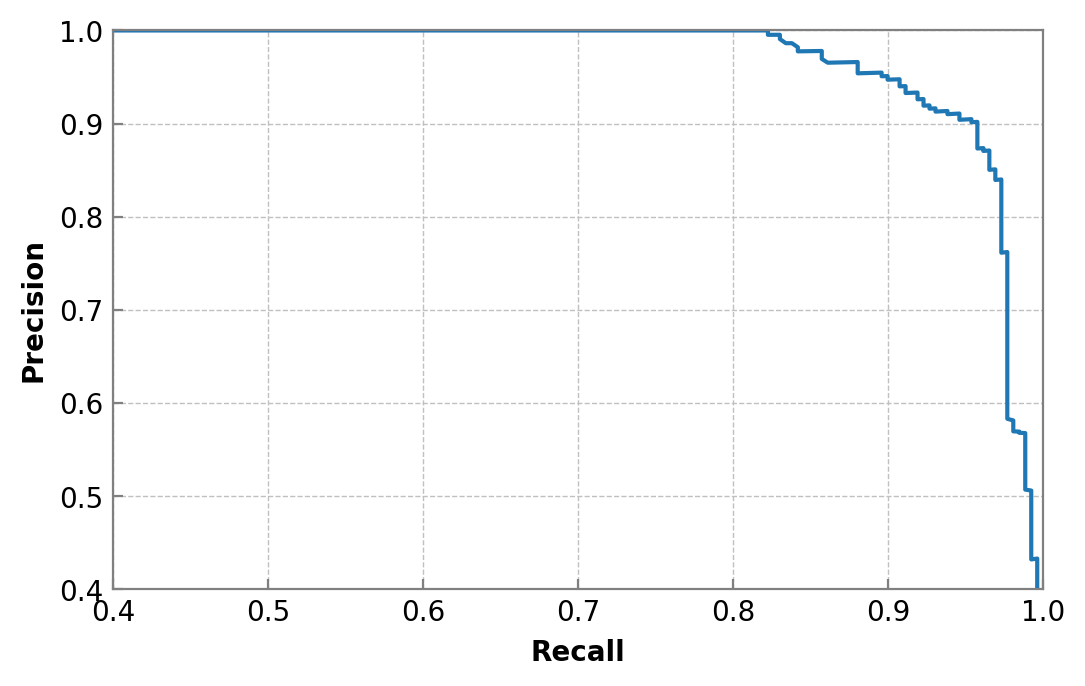

In [14]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    if p > 0:
        ps.append(p)
        rs.append(r)
    else:
        ps.append(1.0)
        rs.append(0.0)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.4, 1.0))
plt.ylim((0.4, 1.0))

_ = plt.plot(rs, ps)